In [1]:
from retina_function import *

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


2021-08-20 08:14:10.449220: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
folder_path = os.getcwd()
documents_direc = folder_path
# getting the path of the retina images and ground truth for RIGA database.
# RIGA retina images
train_images = natsorted(glob(os.path.join(documents_direc,"data","archlight","train_/retina","*.*")))
valid_images = natsorted(glob(os.path.join(documents_direc,"data","archlight","valid_/retina","*.*")))
test_images = natsorted(glob(os.path.join(documents_direc,"data","archlight","test_/retina","*.*")))

# Archlight retina masks for train
ground_truth_train_cup = natsorted(glob(os.path.join(documents_direc,"data","archlight","mask_train/cup/retina","*.*")))
ground_truth_train_disc = natsorted(glob(os.path.join(documents_direc,"data","archlight","mask_train/disc/retina","*.*")))

# Archlight retina masks for valid
ground_truth_valid_cup = natsorted(glob(os.path.join(documents_direc,"data","archlight","mask_valid/cup/retina","*.*")))
ground_truth_valid_disc = natsorted(glob(os.path.join(documents_direc,"data","archlight","mask_valid/disc/retina","*.*")))

# Archlight retina masks for test
ground_truth_test_cup = natsorted(glob(os.path.join(documents_direc,"data","archlight","mask_test/cup/retina","*.*")))
ground_truth_test_disc = natsorted(glob(os.path.join(documents_direc,"data","archlight","mask_test/disc/retina","*.*")))

In [3]:
# loading the models, using the saved model_weights
disc_model_weight = os.path.join(documents_direc,"data","archlight","files","archlight_model_disc.h5")
cup_model_weight = os.path.join(documents_direc,"data","archlight","files","archlight_model_cup.h5")

archlight_disc_model = models.load_model(disc_model_weight, custom_objects={'focal_tversky_loss': focal_tversky_loss, 'dice_coef':dice_coef, 'iou':iou})

2021-08-20 08:14:12.435225: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-20 08:14:12.440196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1034] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-20 08:14:12.440578: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7085GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2021-08-20 08:14:12.440623: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-20 08:14:12.444096: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-20 08:14:12.444147: I tensorflow/stream_execut

In [4]:
def show_oc_and_od(axes, image, title):
    axes.imshow(image, cmap='gray')
    axes.set_title(title)
    axes.axis('off')
    


def pred_and_save(image_, image_mask, model):
    scores = []
    images = []
    dict_score = {}
    for a in range(len(image_)):
        image = cv.imread(image_[a])
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        img = cv.resize(image, (400,400))
        img_yuv = cv.cvtColor(img, cv.COLOR_RGB2YUV)
        clahe = cv.createCLAHE(clipLimit=1, tileGridSize=(2,2))
        img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])
        img = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)
        img_1 = cv.bilateralFilter(img, 9, 75, 75)
        img = img_1.copy()

        
        x = img/255.0
        x = x.astype(np.float32)
        x = np.expand_dims(x, axis=0)
        
        y_pred = model.predict(x)[0]
        y_pred = np.where(y_pred > 0.5, 1.0, 0.0)

        y_pred_ = y_pred.copy()
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = cv.resize(y_pred, (400,400))
        kernel = np.ones((15,15), np.uint8)
        y_pred = cv.morphologyEx(y_pred, cv.MORPH_OPEN, kernel)
        
        y_pred = get_largest_contour(y_pred)
        y_pred = color_mask(y_pred)
        y_pred = y_pred.astype(np.float32)
        y_pred = y_pred / 255.0
        
        y_true = cv.imread(image_mask[a])
        y_true = cv.cvtColor(y_true,cv.COLOR_BGR2GRAY)
        y_true = y_true.astype(np.float32)
        y_true = y_true/255.
        score = dice_coef(y_true, y_pred.astype(np.float32), smooth=1)
        scores.append(float(score))
        images.append(y_pred)
        dict_score[a] = float(score)
    return np.mean(scores) * 100, dict_score, images, scores


# model prediction for Disc
train_score_1, dict_list_train_1, images_train_1, scores_train_1 = pred_and_save(
    train_images, ground_truth_train_disc, archlight_disc_model)
valid_score_1, dict_list_valid_1, images_valid_1, scores_valid_1 = pred_and_save(
    valid_images, ground_truth_valid_disc, archlight_disc_model)
test_score_1, dict_list_test_1, images_test_1, scores_test_1 = pred_and_save(
    test_images, ground_truth_test_disc, archlight_disc_model)

#
dict_list_train_1= sorted(dict_list_train_1, reverse=True)[:4]
scores_train_1 = sorted(scores_train_1, reverse=True)[:4]

dict_list_valid_1= sorted(dict_list_valid_1, reverse=True)[:4]
scores_valid_1 = sorted(scores_valid_1, reverse=True)[:4]

dict_list_test_1= sorted(dict_list_test_1, reverse=True)[:4]
scores_test_1 = sorted(scores_test_1, reverse=True)[:4]

2021-08-20 08:14:13.304074: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-20 08:14:13.304588: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3199980000 Hz
2021-08-20 08:14:13.596111: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-20 08:14:13.850187: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8201
2021-08-20 08:14:14.179082: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-20 08:14:14.436206: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


In [5]:
archlight_cup_model = models.load_model(cup_model_weight, custom_objects={'dice_loss': dice_loss, 'dice_coef':dice_coef, 'iou':iou})

In [6]:
# model prediction for Cup
train_score_2, dict_list_train_2, images_train_2, scores_train_2 = pred_and_save(
    train_images, ground_truth_train_cup, archlight_cup_model)
valid_score_2, dict_list_valid_2, images_valid_2, scores_valid_2 = pred_and_save(
    valid_images, ground_truth_valid_disc, archlight_cup_model)
test_score_2, dict_list_test_2, images_test_2, scores_test_2 = pred_and_save(
    test_images, ground_truth_test_disc, archlight_cup_model)

In [7]:
from scipy import ndimage as ndi
from skimage.segmentation import clear_border, mark_boundaries
from skimage.measure import label, regionprops

In [8]:

def get_mask_area(mask):
    mask = mask.astype(np.uint8)

    #ret,thresh = cv.threshold(selected_slice_b, 40, 255)

    #edge = cv.Canny(selected_slice_b, 175, 175)
    contours,hierarchy = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Find the index of the largest contour
    if len(contours) == 0:
        mask_area = 0.0
    else:
        areas = [cv.contourArea(c) for c in contours]
        # the largest contour shows the vertical disc or cup area.
        mask_area = max(areas)
    
    return mask_area

def get_marker(image, pred_disc, pred_cup):
    compared_image = mark_boundaries(image, pred_disc, mode='thick', outline_color=(0,255,255), color = (0,255,255))
    compared_image = mark_boundaries(compared_image, pred_cup, mode='thick', outline_color=(0,0,255), color = (0,0,255))
    
    return compared_image


### Performing CDR analysis for predicted Optic Disc and Optic Cup

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


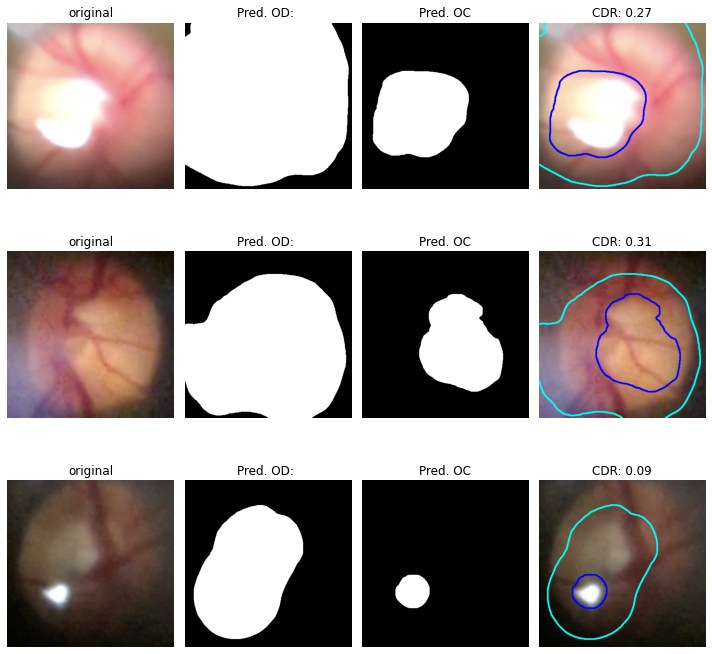

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10,10))
b= 0
for a in range(1,len(dict_list_train_1)):
    # original image
    image = cv.imread(train_images[dict_list_train_1[a]])
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    # predicted disc 
    pred_disc = images_train_1[dict_list_train_1[a]]
    disc_area = get_mask_area(pred_disc) # getting the disc area.
    
    # predicted cup
    pred_cup = images_train_2[dict_list_train_1[a]]
    cup_area = get_mask_area(pred_cup) # getting the cup area.
    
    # getting the CDR
    # masking the image, optic disc and optic cup together.
    combined_image = get_marker(image, pred_disc, pred_cup)
    cdr = round(cup_area/disc_area, 2)
    
    show_oc_and_od(ax[b,0], image, "original")
    show_oc_and_od(ax[b,1], pred_disc, "Pred. OD: ")
    show_oc_and_od(ax[b,2], pred_cup, "Pred. OC")
    show_oc_and_od(ax[b,3], combined_image, "CDR: "+str(cdr))
    b+=1

plt.tight_layout()
plt.show()

### Comparative analysis of predicted mask with Ground truth mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


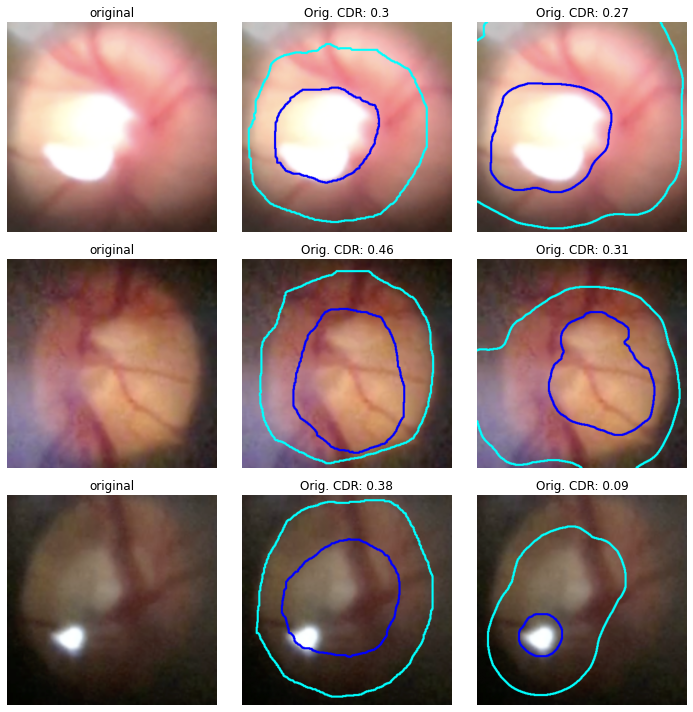

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
b= 0
for a in range(1,len(dict_list_train_1)):
    # original image
    image = cv.imread(train_images[dict_list_train_1[a]])
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    # ground truth disc
    disc = cv.imread(ground_truth_train_disc[dict_list_train_1[a]])
    disc = cv.cvtColor(disc, cv.COLOR_BGR2GRAY)
    orig_disc_area = get_mask_area(disc) # get the disc area 
    # ground truth cup
    cup = cv.imread(ground_truth_train_cup[dict_list_train_1[a]])
    cup = cv.cvtColor(cup, cv.COLOR_BGR2GRAY)
    orig_cup_area = get_mask_area(cup) # get the cup area
    # overlapping the orig_disc, cup and image
    combined_image_orig = get_marker(image, disc, cup)
    cdr_orig = round(orig_cup_area/orig_disc_area, 2)


    
    # predicted disc 
    pred_disc = images_train_1[dict_list_train_1[a]]
    disc_area = get_mask_area(pred_disc) # getting the disc area.
    # predicted cup
    pred_cup = images_train_2[dict_list_train_1[a]]
    cup_area = get_mask_area(pred_cup) # getting the cup area.
    # getting the CDR
    # oevrlapping the image, optic disc and optic cup together.
    combined_image_pred = get_marker(image, pred_disc, pred_cup)
    cdr_pred = round(cup_area/disc_area, 2)
    
    show_oc_and_od(ax[b,0], image, "original")
    show_oc_and_od(ax[b,1], combined_image_orig, "Orig. CDR: "+str(cdr_orig))
    show_oc_and_od(ax[b,2], combined_image_pred, "Orig. CDR: "+str(cdr_pred))
    b+=1

plt.tight_layout()
plt.show()